## Introduction


### Time Series with External Regressors

This is a note on working with time series *with* external regressors, *and* specifying if the external regressors are treated as transient (short impulse response) or durable (long term impulse response).

The generative system we are interested in is the following with `y_auto` unobserved and `y` observed.

```
  y_auto[i] ~ b_auto_0 + b_auto . (y_auto[i-l1], ..., y_auto[i-lk]) + b_z . z[i]
  y[i] ~ y_auto[i] + b_x . x[i]
```

Where l1, ..., lk are our lags, z[] are durable external regressors, and x[] are transient external regressors.

We will call external regressors that do not contribute to future time indices (as above) "transient". Our data will be so generated, and we will see models that are structured to expect this structure outperform models that are not so structured. We will call any external regressors in the `y_auto` series "durable" as they (indirectly) affect future measurements. We will call a model that matches the structure of the assumed data generating process as "structure respecting", and one that does not as "disrespecting." Having a good guess of the model structure is a positive and useful inductive bias.

The above distinction is dealing with durable AR (or auto-regressive, or infinite impulse response) issues in external regressors (in addition to AR issues in observations), and transient MA (or "moving average", though the term merely means finite impulse response in time series work- not an actual "moving average").

On terminology: from Box, Jenkins, Reinsel, *Time Series Analysis: Forecasting and Control*, 4th Edition, Wiley, 2008 (Introduction p. 10) we have the following.

> The name "moving average" is somewhat misleading because the weights 1, -&theta;<sub>1</sub>, -&theta;<sub>2</sub>, ... -&theta;<sub>q</sub>, which multiply the a's need not total to unity nor need they be positive. However, this nomenclature is in common use, and therefore we employ it.


## Setting up our example


In [1]:
# set up Python
import json
import numpy as np
import pandas as pd
import plotnine
from plotnine import *

from nested_model_fns import (
    build_example, 
    train_test_split, 
    plot_model_quality,
    apply_linear_model_bundle_method,
)


# set plot size
plotnine.options.figure_size = (16, 8)


In [2]:
rng = np.random.default_rng(2024)


Our example data is as follows.


In [3]:
# specify example
generating_lags = (1, 2)
modeling_lags = (1, 2)
gen_scale = 5.2
gen_shift = 10.0
b_auto = (2 * np.cos(np.pi/20), -1)  # angle addition
b_auto_0 = gen_scale * gen_shift * (1 - np.sum(b_auto))
# external regressors
b_z = (14.2, )
b_x = (16.1, )

generating_params = {
    'b_auto_0': b_auto_0,
    'b_auto': b_auto,
    'b_z': b_z,
    'b_x': b_x,
    'generating_lags': generating_lags,
    'modeling_lags': modeling_lags,
}

# show original generative parameters
generating_params


{'b_auto_0': 1.2804125781056719,
 'b_auto': (1.9753766811902755, -1),
 'b_z': (14.2,),
 'b_x': (16.1,),
 'generating_lags': (1, 2),
 'modeling_lags': (1, 2)}

In [4]:
with open("generating_params.json", "w") as file:
    json.dump(generating_params, file)

In [5]:
# build the example
d_example = build_example(
    rng=rng,
    generating_lags=generating_lags,
    b_auto=b_auto,
    b_auto_0=b_auto_0,
    b_z=b_z,
    b_x=b_x,
)

d_example['ext_regressors'] = [
    f'z_0: {z_0}, x_0: {x_0}' 
    for z_0, x_0 in zip(d_example['z_0'], d_example['x_0'])]


In [6]:
# split into test and train by time
d_train, d_test = train_test_split(d_example, test_length=20)
d_train.to_csv("d_train.csv", index=False)
d_test.to_csv("d_test.csv", index=False)


In [7]:
# show training data
d_train


,time_tick,z_0,x_0,y,ext_regressors
0,0,0,0,52.873288,"z_0: 0, x_0: 0"
1,1,0,1,69.679317,"z_0: 0, x_0: 1"
2,2,0,0,55.003274,"z_0: 0, x_0: 0"
3,3,0,0,56.025156,"z_0: 0, x_0: 0"
4,4,1,0,70.415189,"z_0: 1, x_0: 0"
...,...,...,...,...,...
975,975,0,0,0.000000,"z_0: 0, x_0: 0"
976,976,0,0,0.000000,"z_0: 0, x_0: 0"
977,977,0,0,2.562078,"z_0: 0, x_0: 0"
978,978,0,1,20.391449,"z_0: 0, x_0: 1"


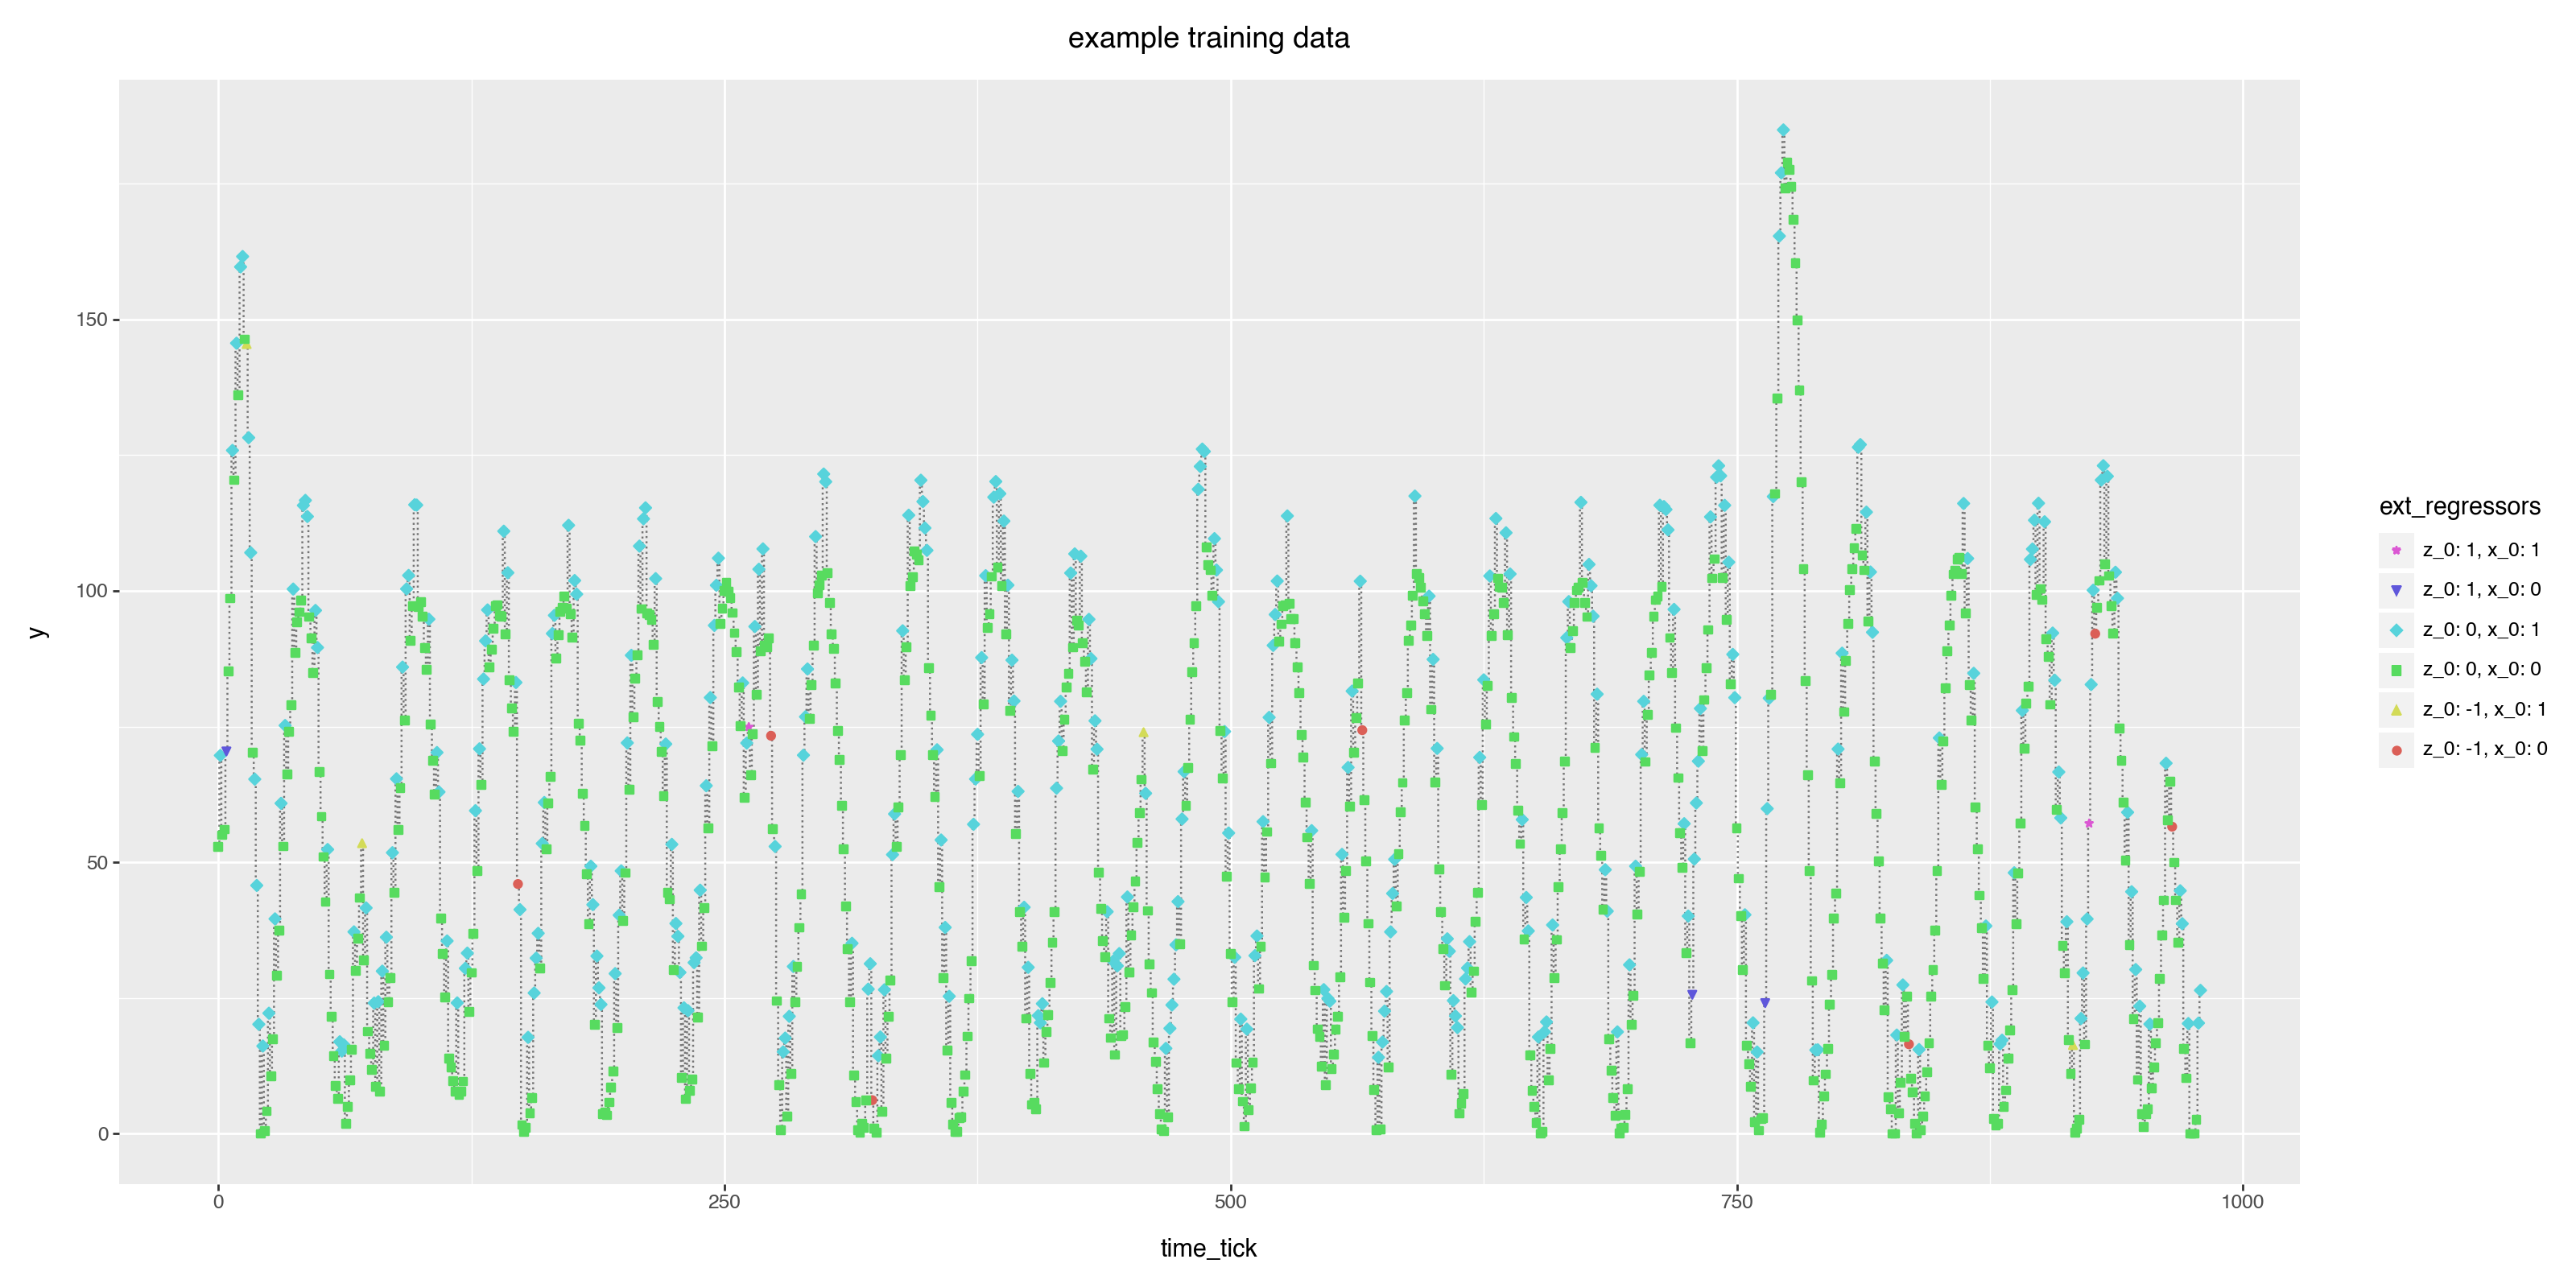

In [8]:
# plot training data
(
    ggplot(
        data=d_train,
        mapping=aes(x='time_tick', y='y')
    )
    + geom_step(
        alpha=0.5, 
        direction='mid', 
        linetype='dotted',
        )
    + geom_point(mapping=aes(shape='ext_regressors', color='ext_regressors'))
    + guides(shape=guide_legend(reverse=True))
    + ggtitle("example training data")
)


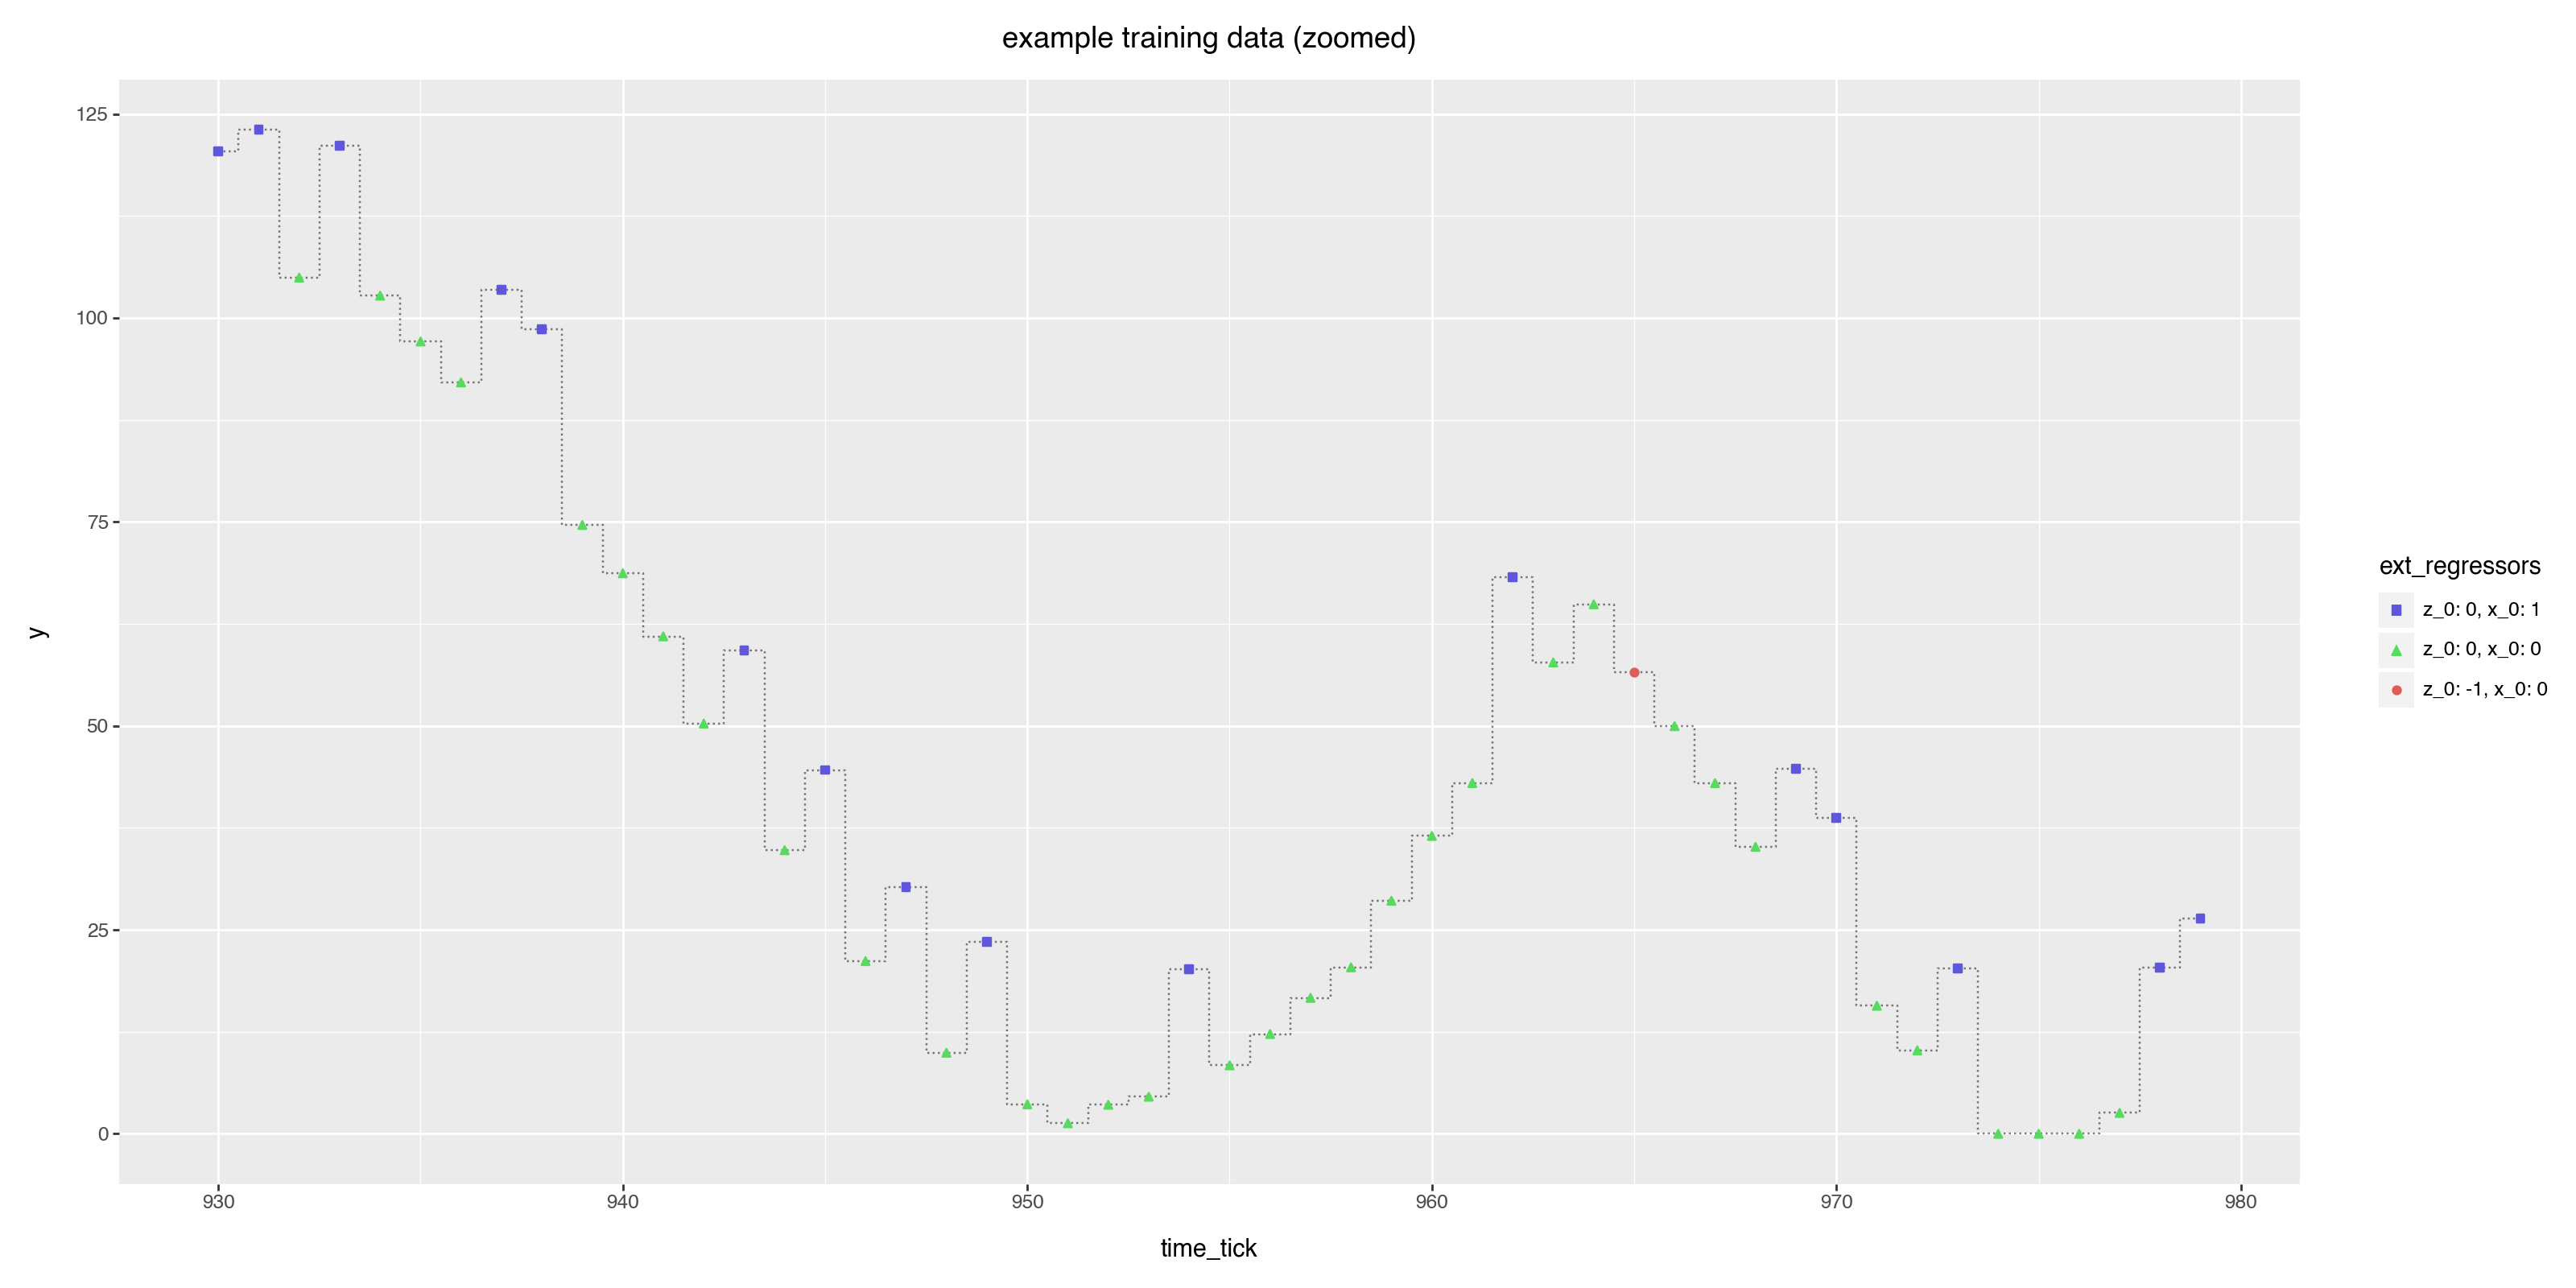

In [9]:
# zoom in on training data and annotate
d_train_zoomed = d_train.loc[
    d_train['time_tick'] >= (d_train.shape[0] - 50), 
    :].reset_index(drop=True, inplace=False)
(
    ggplot(
        data=d_train_zoomed,
        mapping=aes(x='time_tick', y='y')
    )
    + geom_step(
        alpha=0.5, 
        direction='mid', 
        linetype='dotted',
        )
    + geom_point(mapping=aes(shape='ext_regressors', color='ext_regressors'))
    + guides(shape=guide_legend(reverse=True))
    + ggtitle("example training data (zoomed)")
)


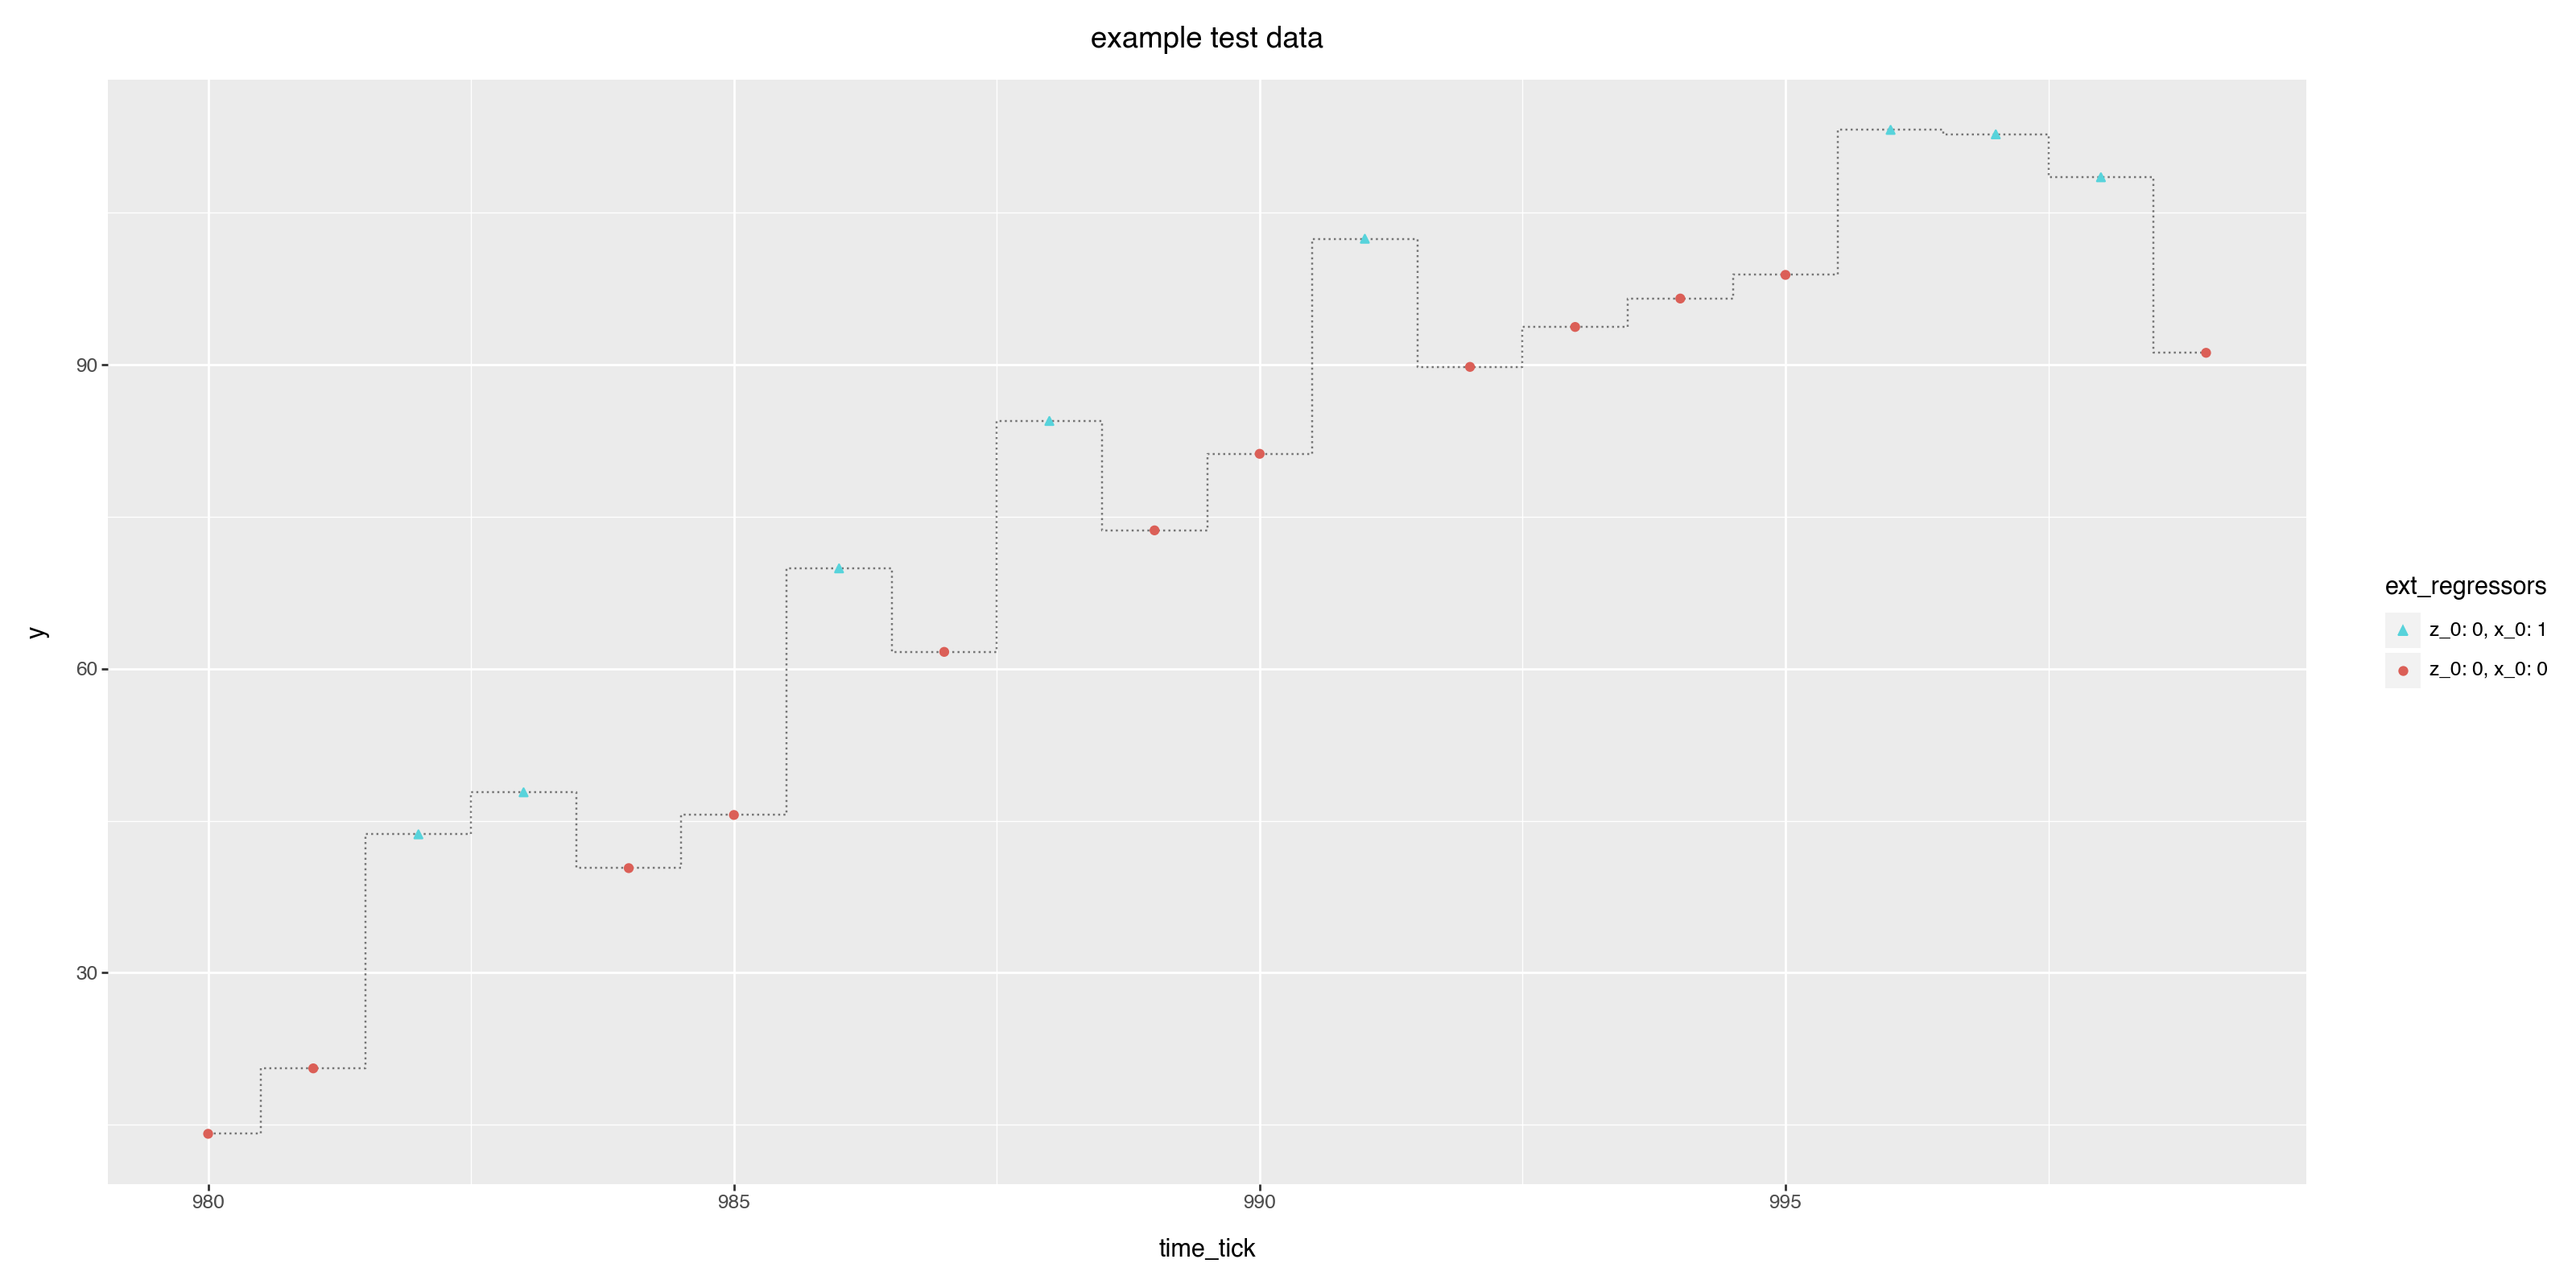

In [10]:
# plot test data
(
    ggplot(
        data=d_test,
        mapping=aes(x='time_tick', y='y')
    )
    + geom_step(
        alpha=0.5, 
        direction='mid', 
        linetype='dotted',
        )
    + geom_point(mapping=aes(shape='ext_regressors', color='ext_regressors'))
    + guides(shape=guide_legend(reverse=True))
    + ggtitle("example test data")
)


## Ignoring External Regressors


Now, let's demonstrate attempting to fit a direct linear model bundle, without external regressors. In this a linear model bundle is a bundle of models which for each <code>k &ge; 0</code>, we predict <code>y[i + k] ~ g(x[i + k]) + f(y[i-l1], y[i-l2], ..., y[i-lk])</code>. The <code>li</code> are positive date/time index lags, and <code>g()</code>, and <code>f()</code> are linear functions to be fit. This formulation is simple, but not quite structure respecting- as the external regressors are modeled as having a durable effect.

In the first case we have no external regressors, so this is <code>y[i + k] ~ f(y[i-l1], y[i-l2], ..., y[i-lk])</code>.


In [11]:
d_test['linear model bundle (no external regressors)'] = apply_linear_model_bundle_method(
    modeling_lags=modeling_lags,
    d_train=d_train,
    d_apply=d_test,
)


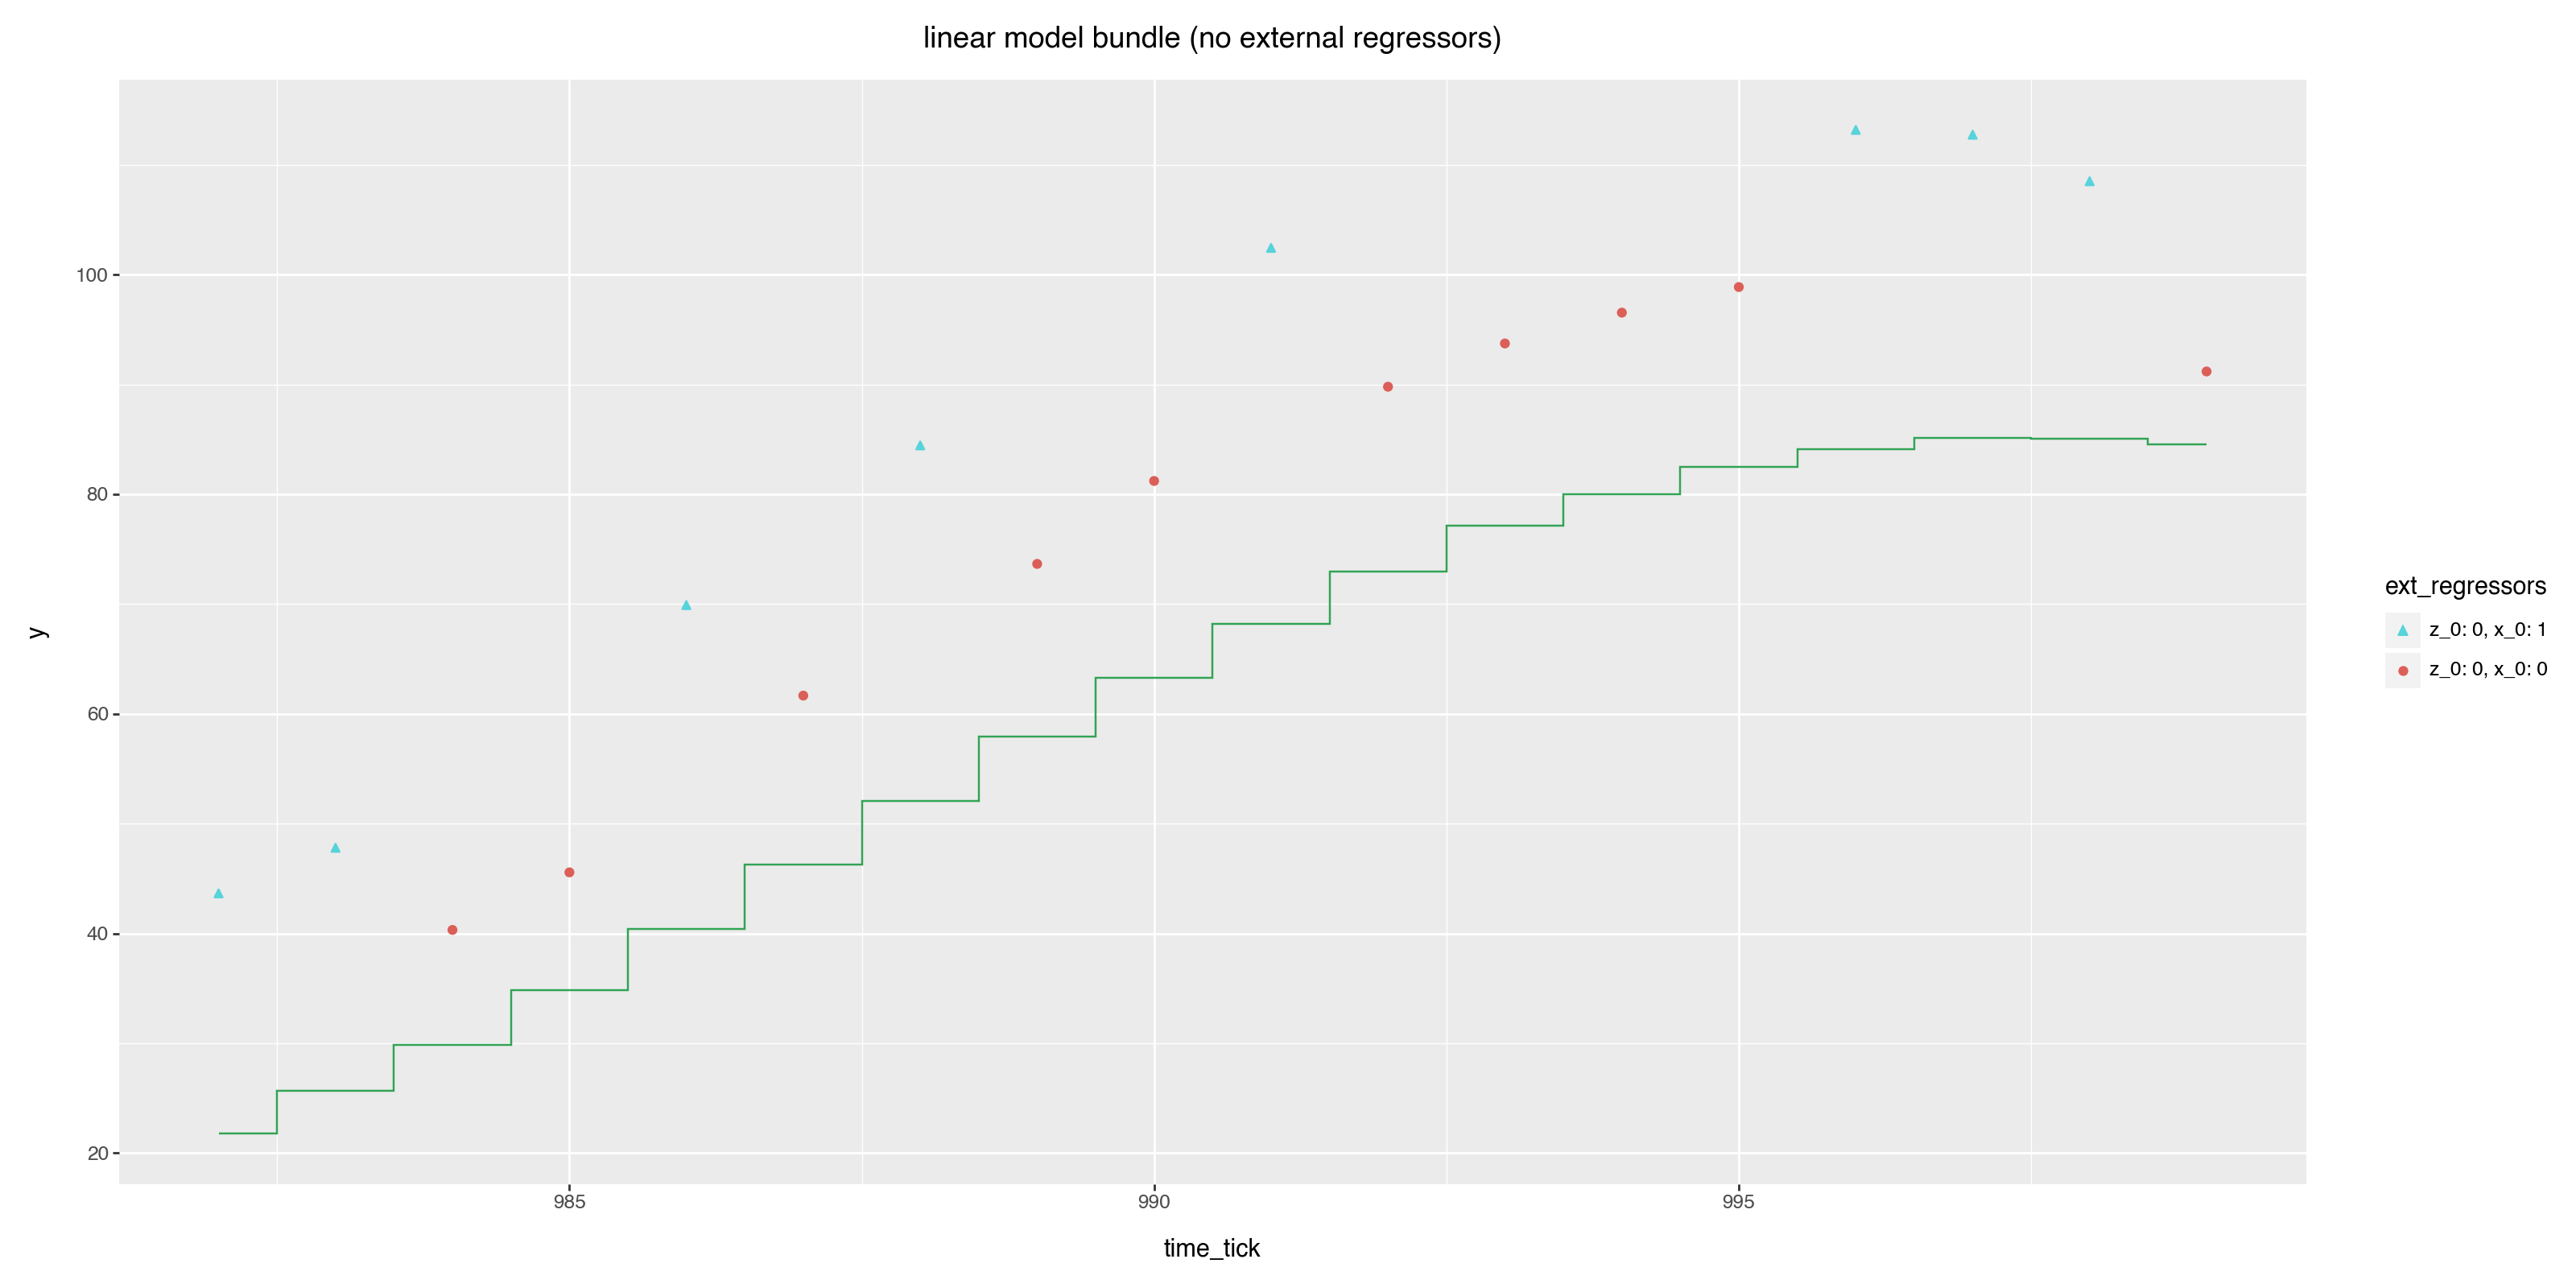

In [12]:
(
    ggplot(
        data=d_test.loc[d_test.notna().all(axis='columns'), :],
        mapping=aes(x='time_tick')
    )
    + geom_point(aes(y='y', shape='ext_regressors', color='ext_regressors'))
    + geom_step(
        aes(y='linear model bundle (no external regressors)'),
        color='#31a354',
        direction='mid',
        )
    + guides(shape=guide_legend(reverse=True))
    + ggtitle("linear model bundle (no external regressors)")
)


As the model has no access the external regressors, it can't take advantage of them and is forced to pick a "mid-path" through previous training data. This path then deviates a lot in out of sample test data, as the un-modeled effect of the external regressors also obscures important forward relations.


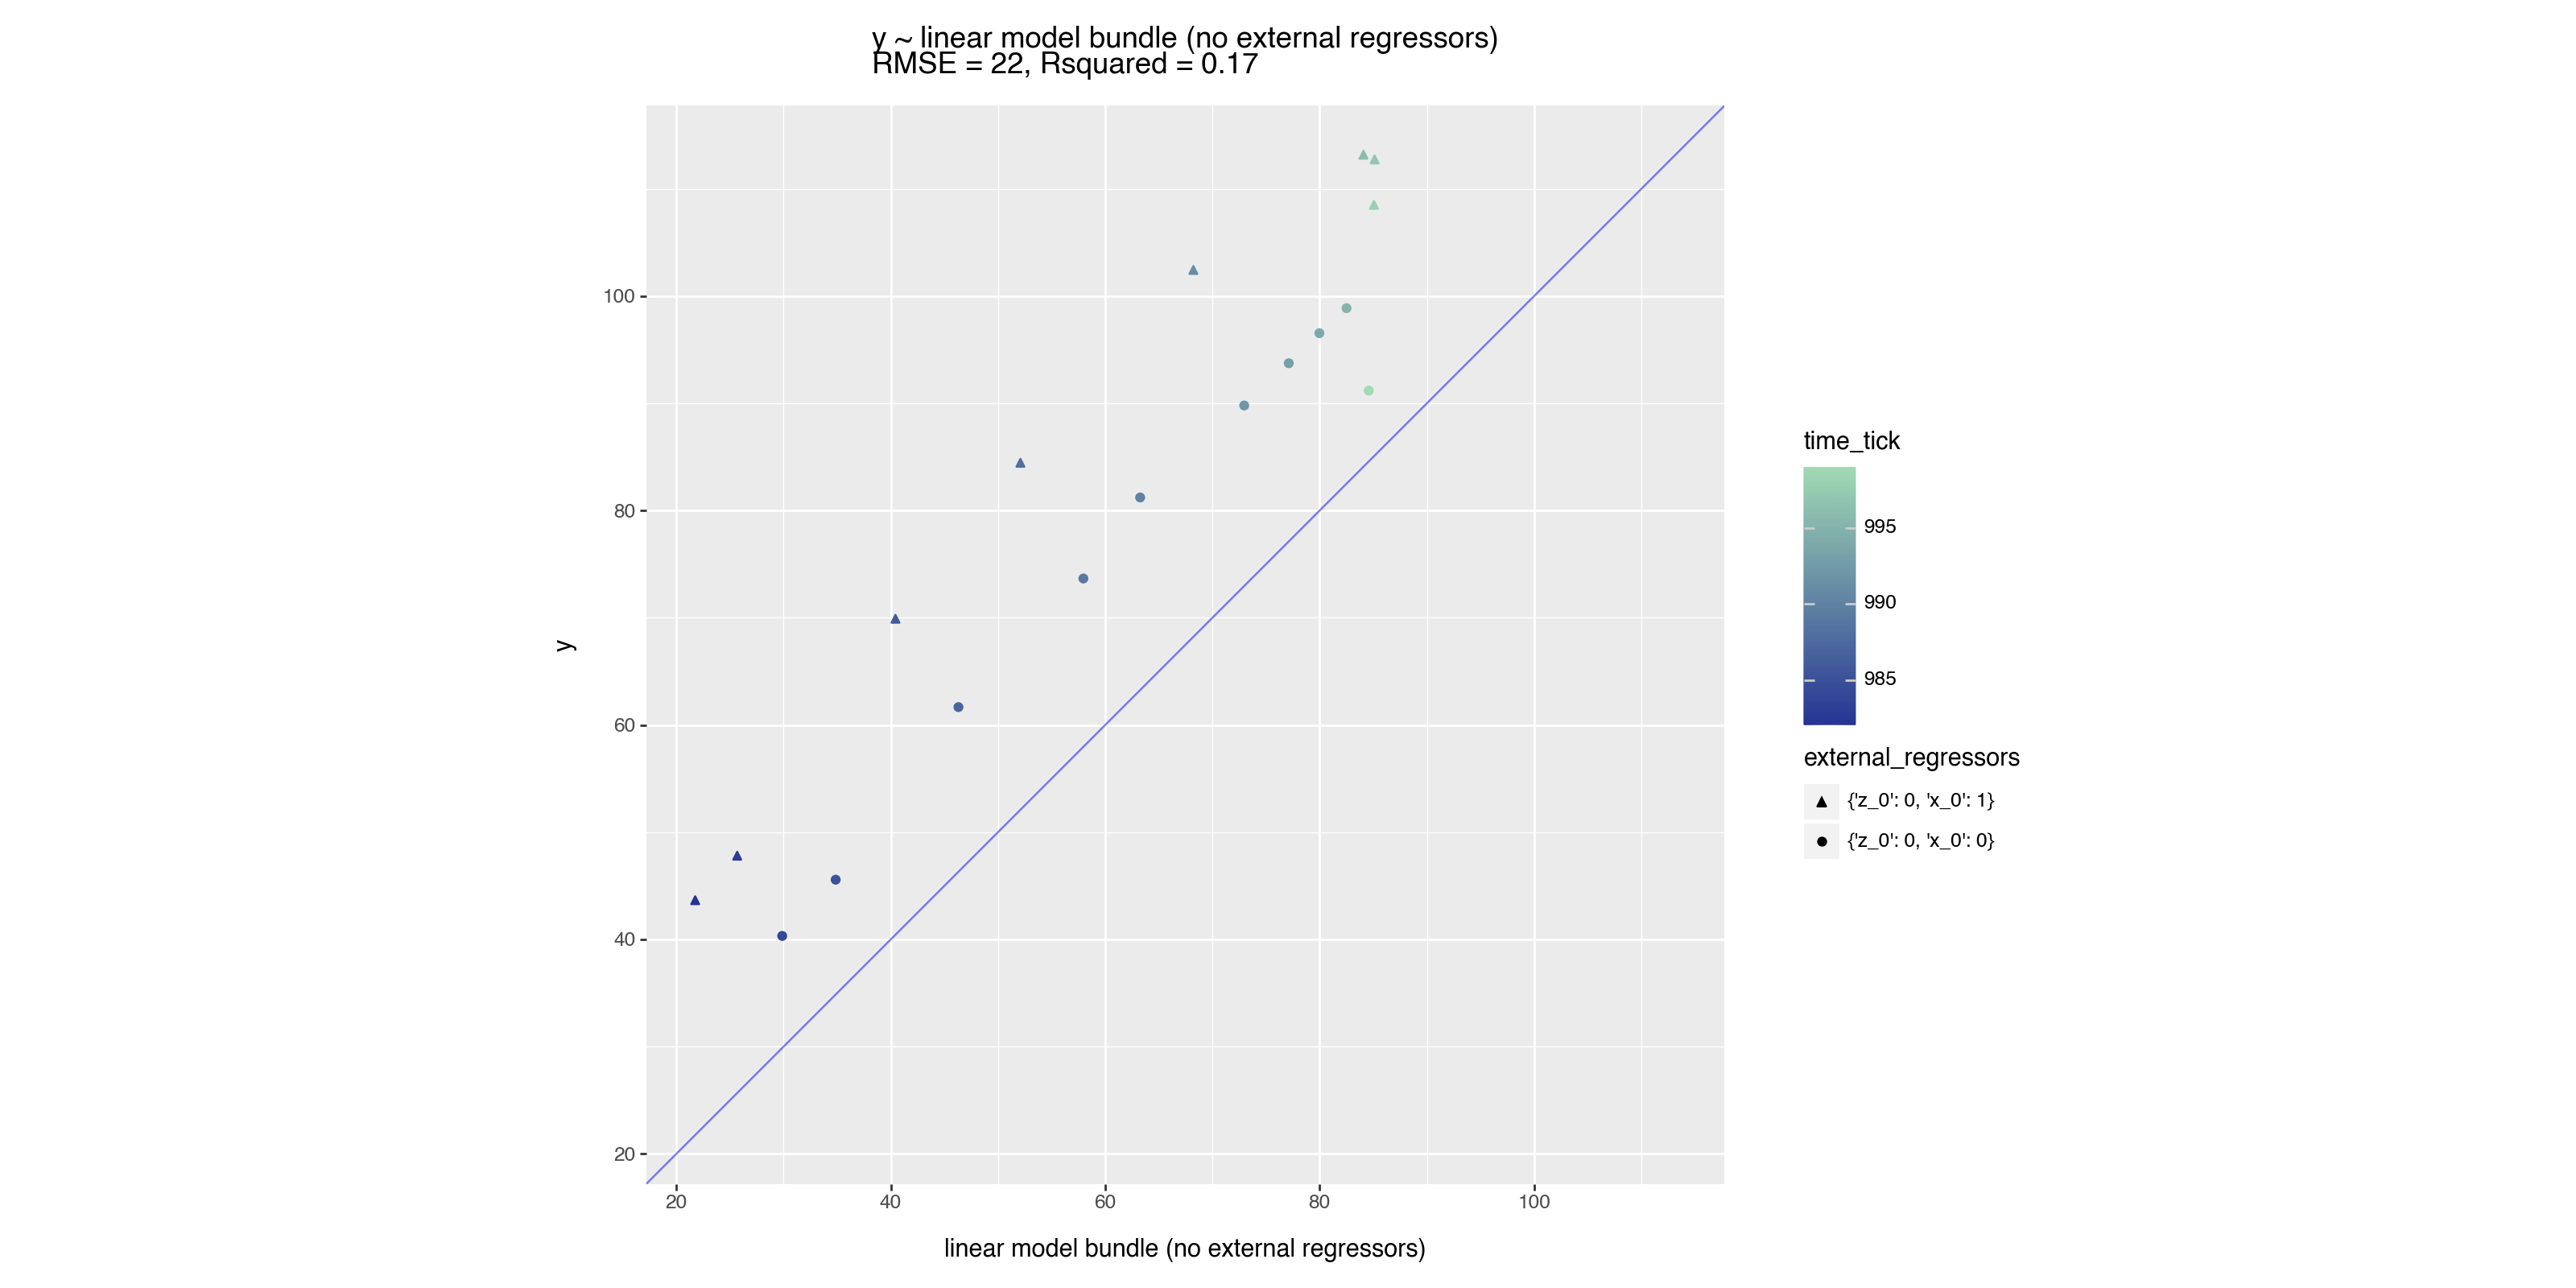

In [13]:
plot_model_quality(
    d_test.loc[pd.isnull(d_test['linear model bundle (no external regressors)']) == False, :],
    result_name='linear model bundle (no external regressors)',
    external_regressors=['z_0', 'x_0'],
)


## Adding in external regressors simplest try (not respecting problem domain structure)


Another thing to try is a linear model bundle with jointly estimated (or, unfortunately, non-structure respecting durable) external regressor effects. We show that here.


In [14]:
d_test['linear model bundle (durable external regressors)'] = apply_linear_model_bundle_method(
    modeling_lags=modeling_lags,
    durable_external_regressors=['z_0', 'x_0'],
    d_train=d_train,
    d_apply=d_test,
)


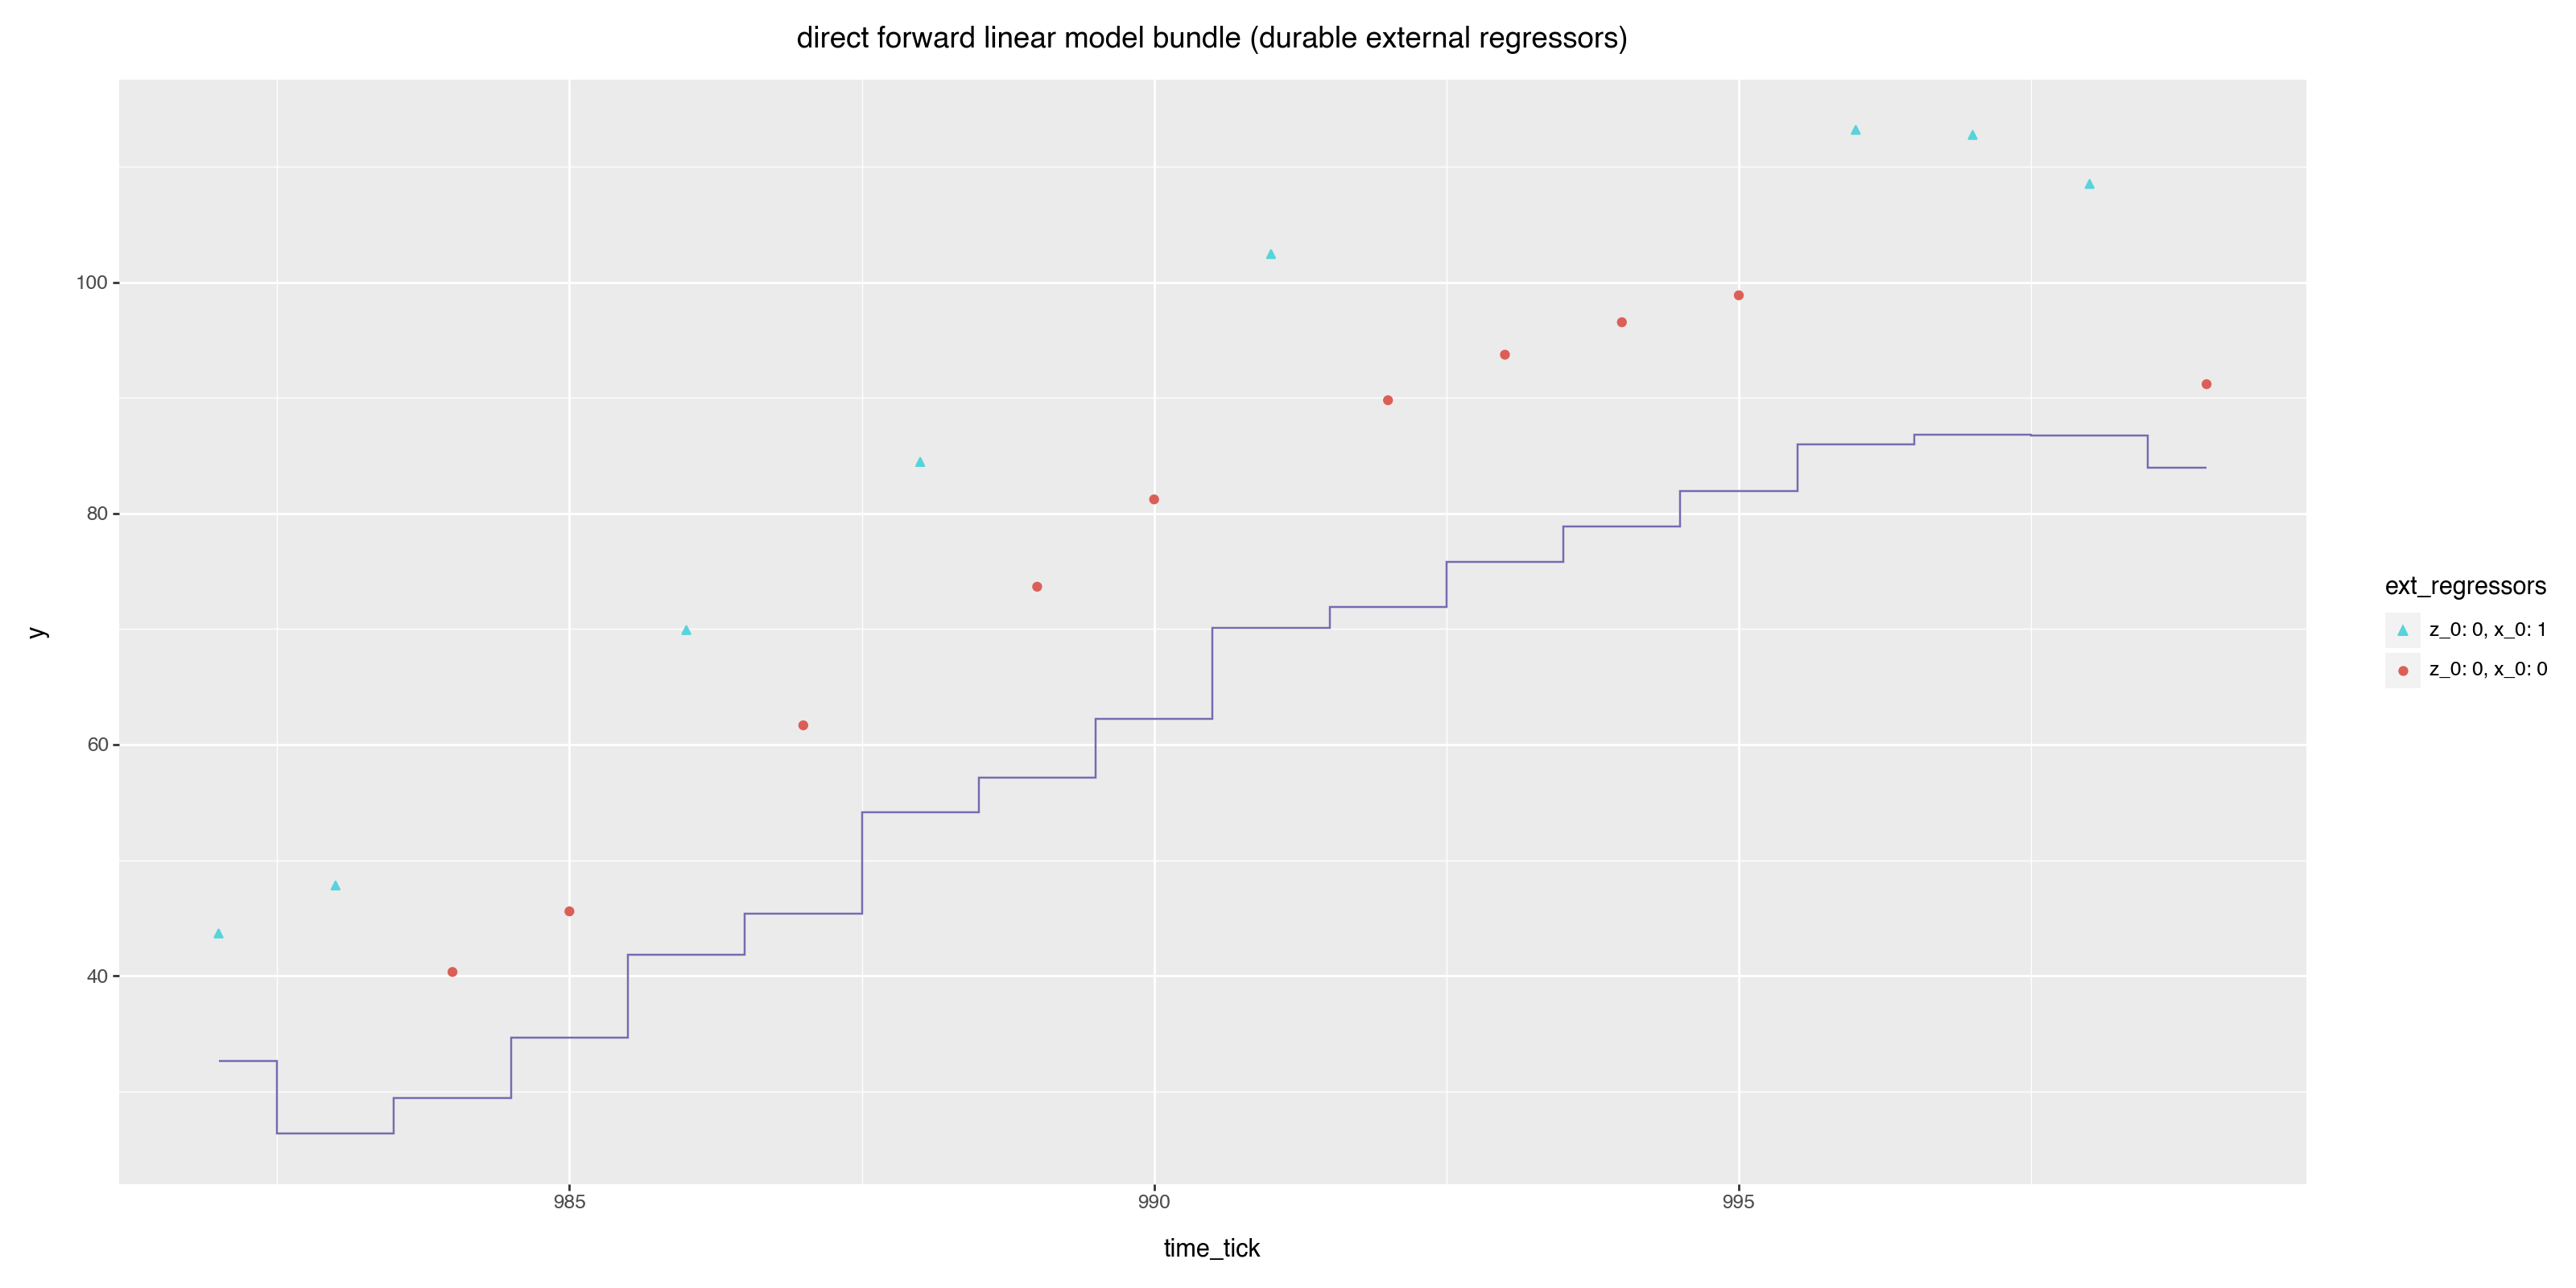

In [15]:
(
    ggplot(
        data=d_test.loc[d_test.notna().all(axis='columns'), :],
        mapping=aes(x='time_tick')
    )
    + geom_point(aes(y='y', shape='ext_regressors', color='ext_regressors'))
    + geom_step(
        aes(y='linear model bundle (durable external regressors)'), 
        color='#756bb1',
        direction='mid',
        )
    + guides(shape=guide_legend(reverse=True))
    + ggtitle("direct forward linear model bundle (durable external regressors)")
)


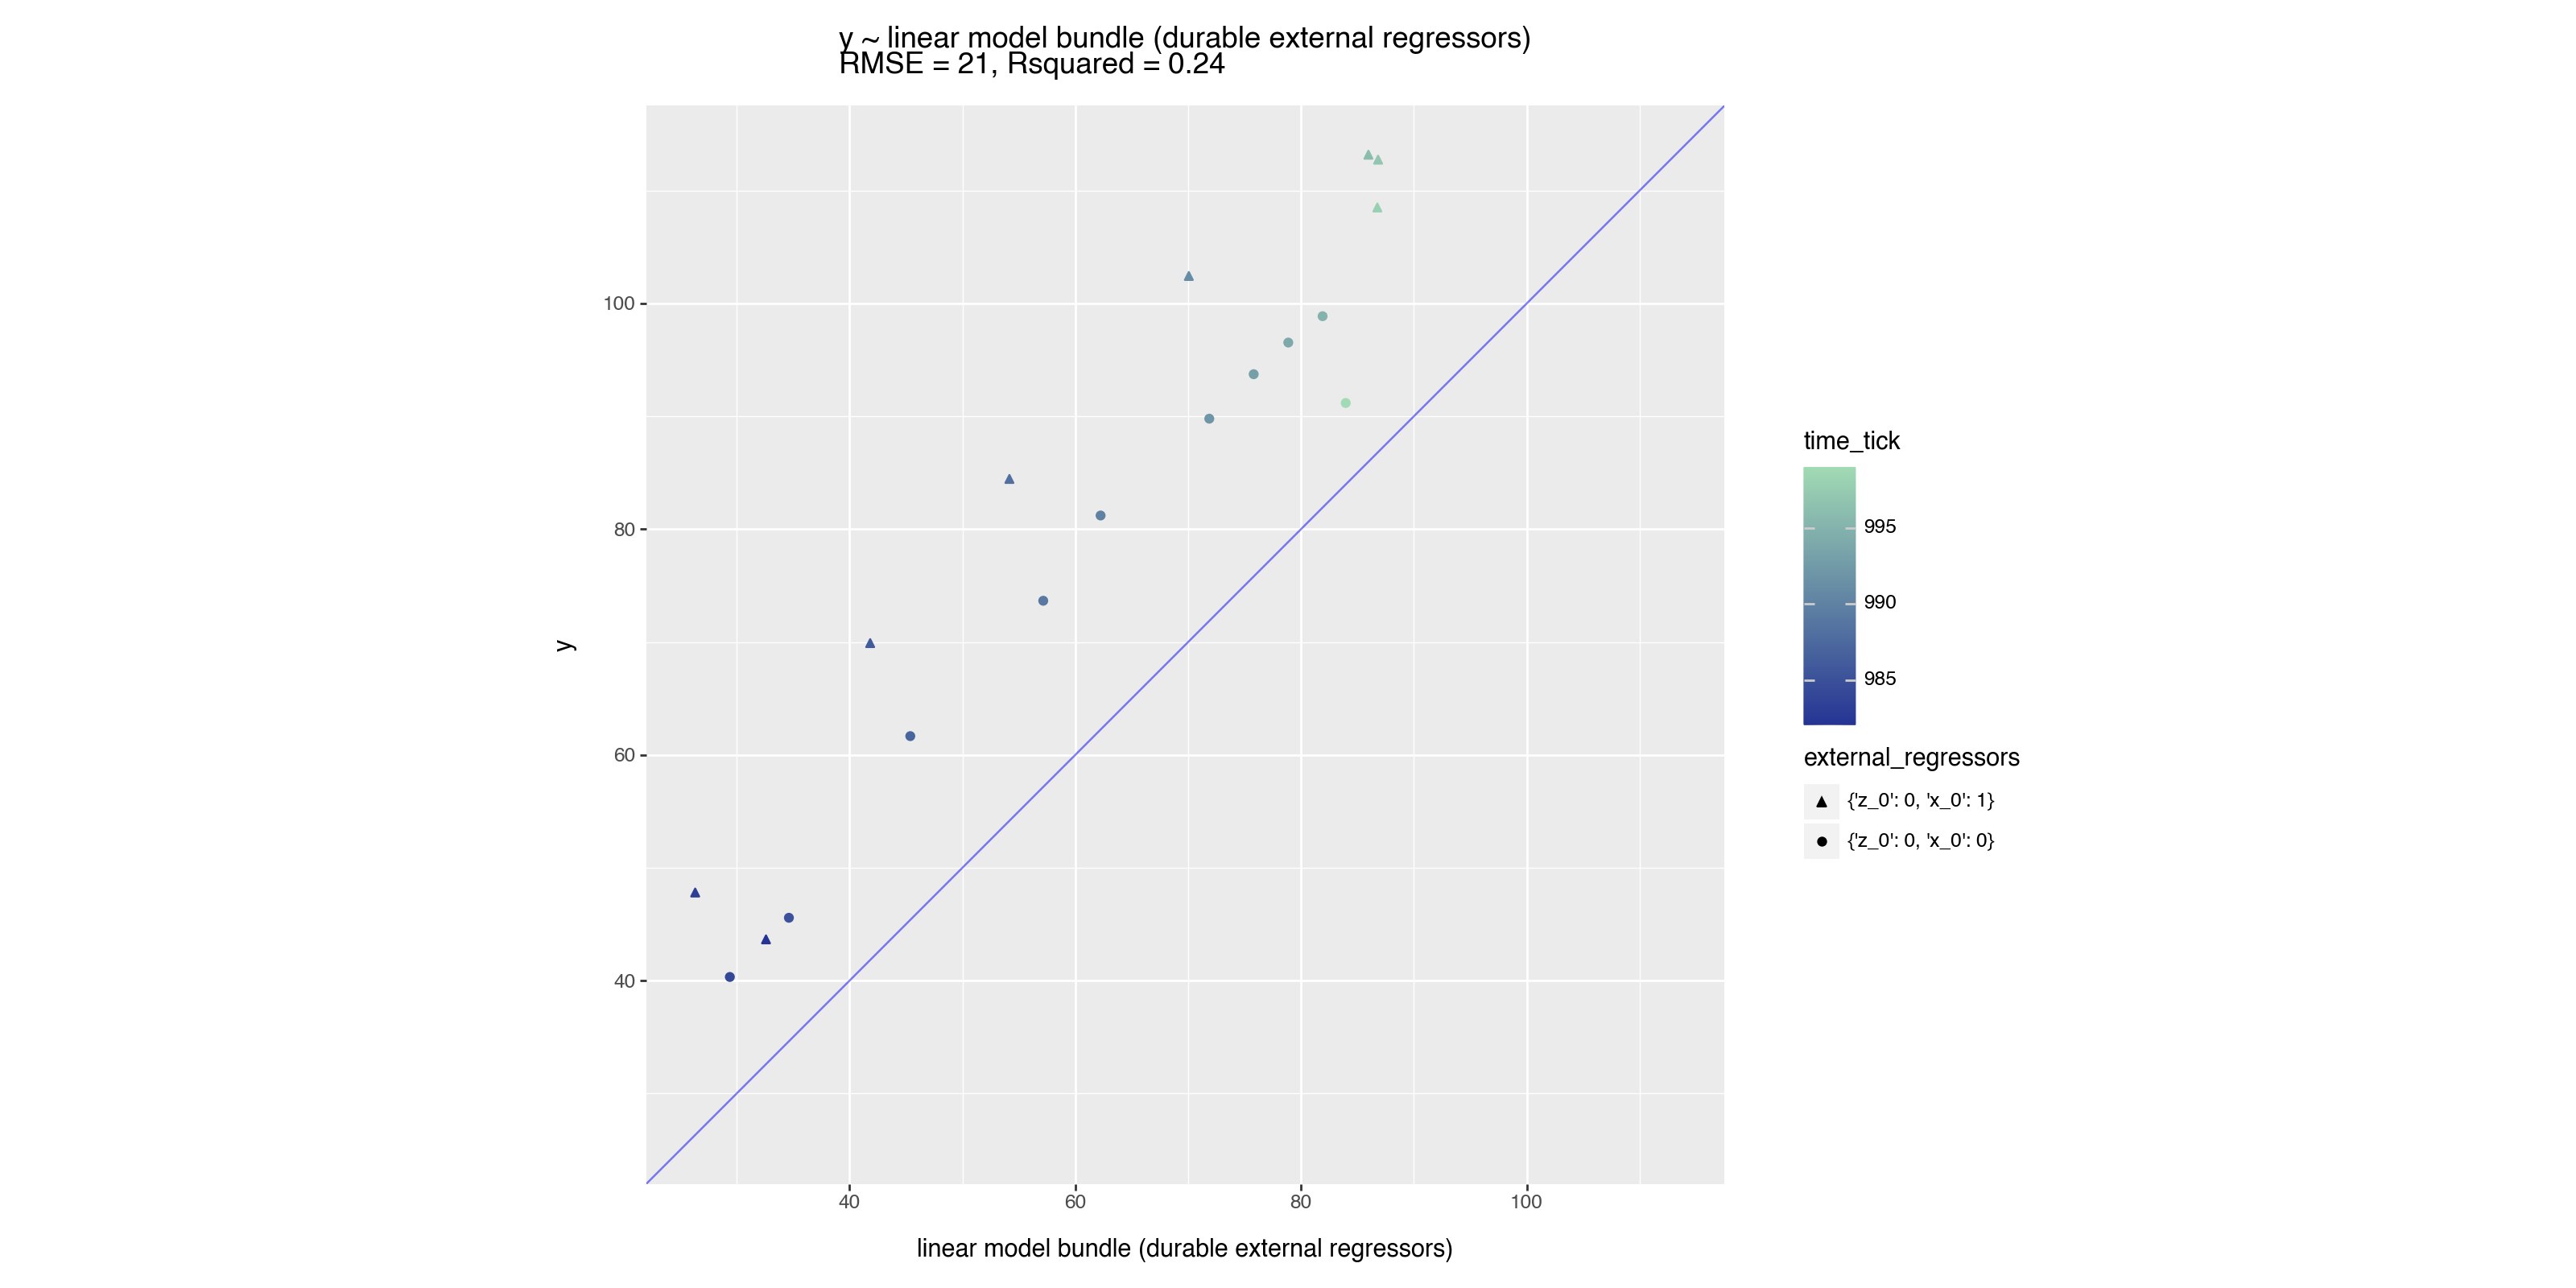

In [16]:
plot_model_quality(
    d_test.loc[pd.isnull(d_test['linear model bundle (durable external regressors)']) == False, :],
    result_name='linear model bundle (durable external regressors)',
    external_regressors=['z_0', 'x_0'],
)


This model has *slightly() better quality, but is not picking up all of the signal.


## Adding external regressors compatible with stated problem structure


Now we try a linear model with a subtracted (pulled-off) pre-estimate of external regressors. This is an attempt to respect the expected transient nature of the external regressors. The estimation method is a bit ad-hoc (being an iterative fraction of variables active estimate), but turns out to be quite powerful.


In [17]:
d_test['linear model bundle (correct external regressor structure)'] = apply_linear_model_bundle_method(
    modeling_lags=modeling_lags,
    durable_external_regressors=['z_0'],
    transient_external_regressors=['x_0'],
    d_train=d_train,
    d_apply=d_test,
)


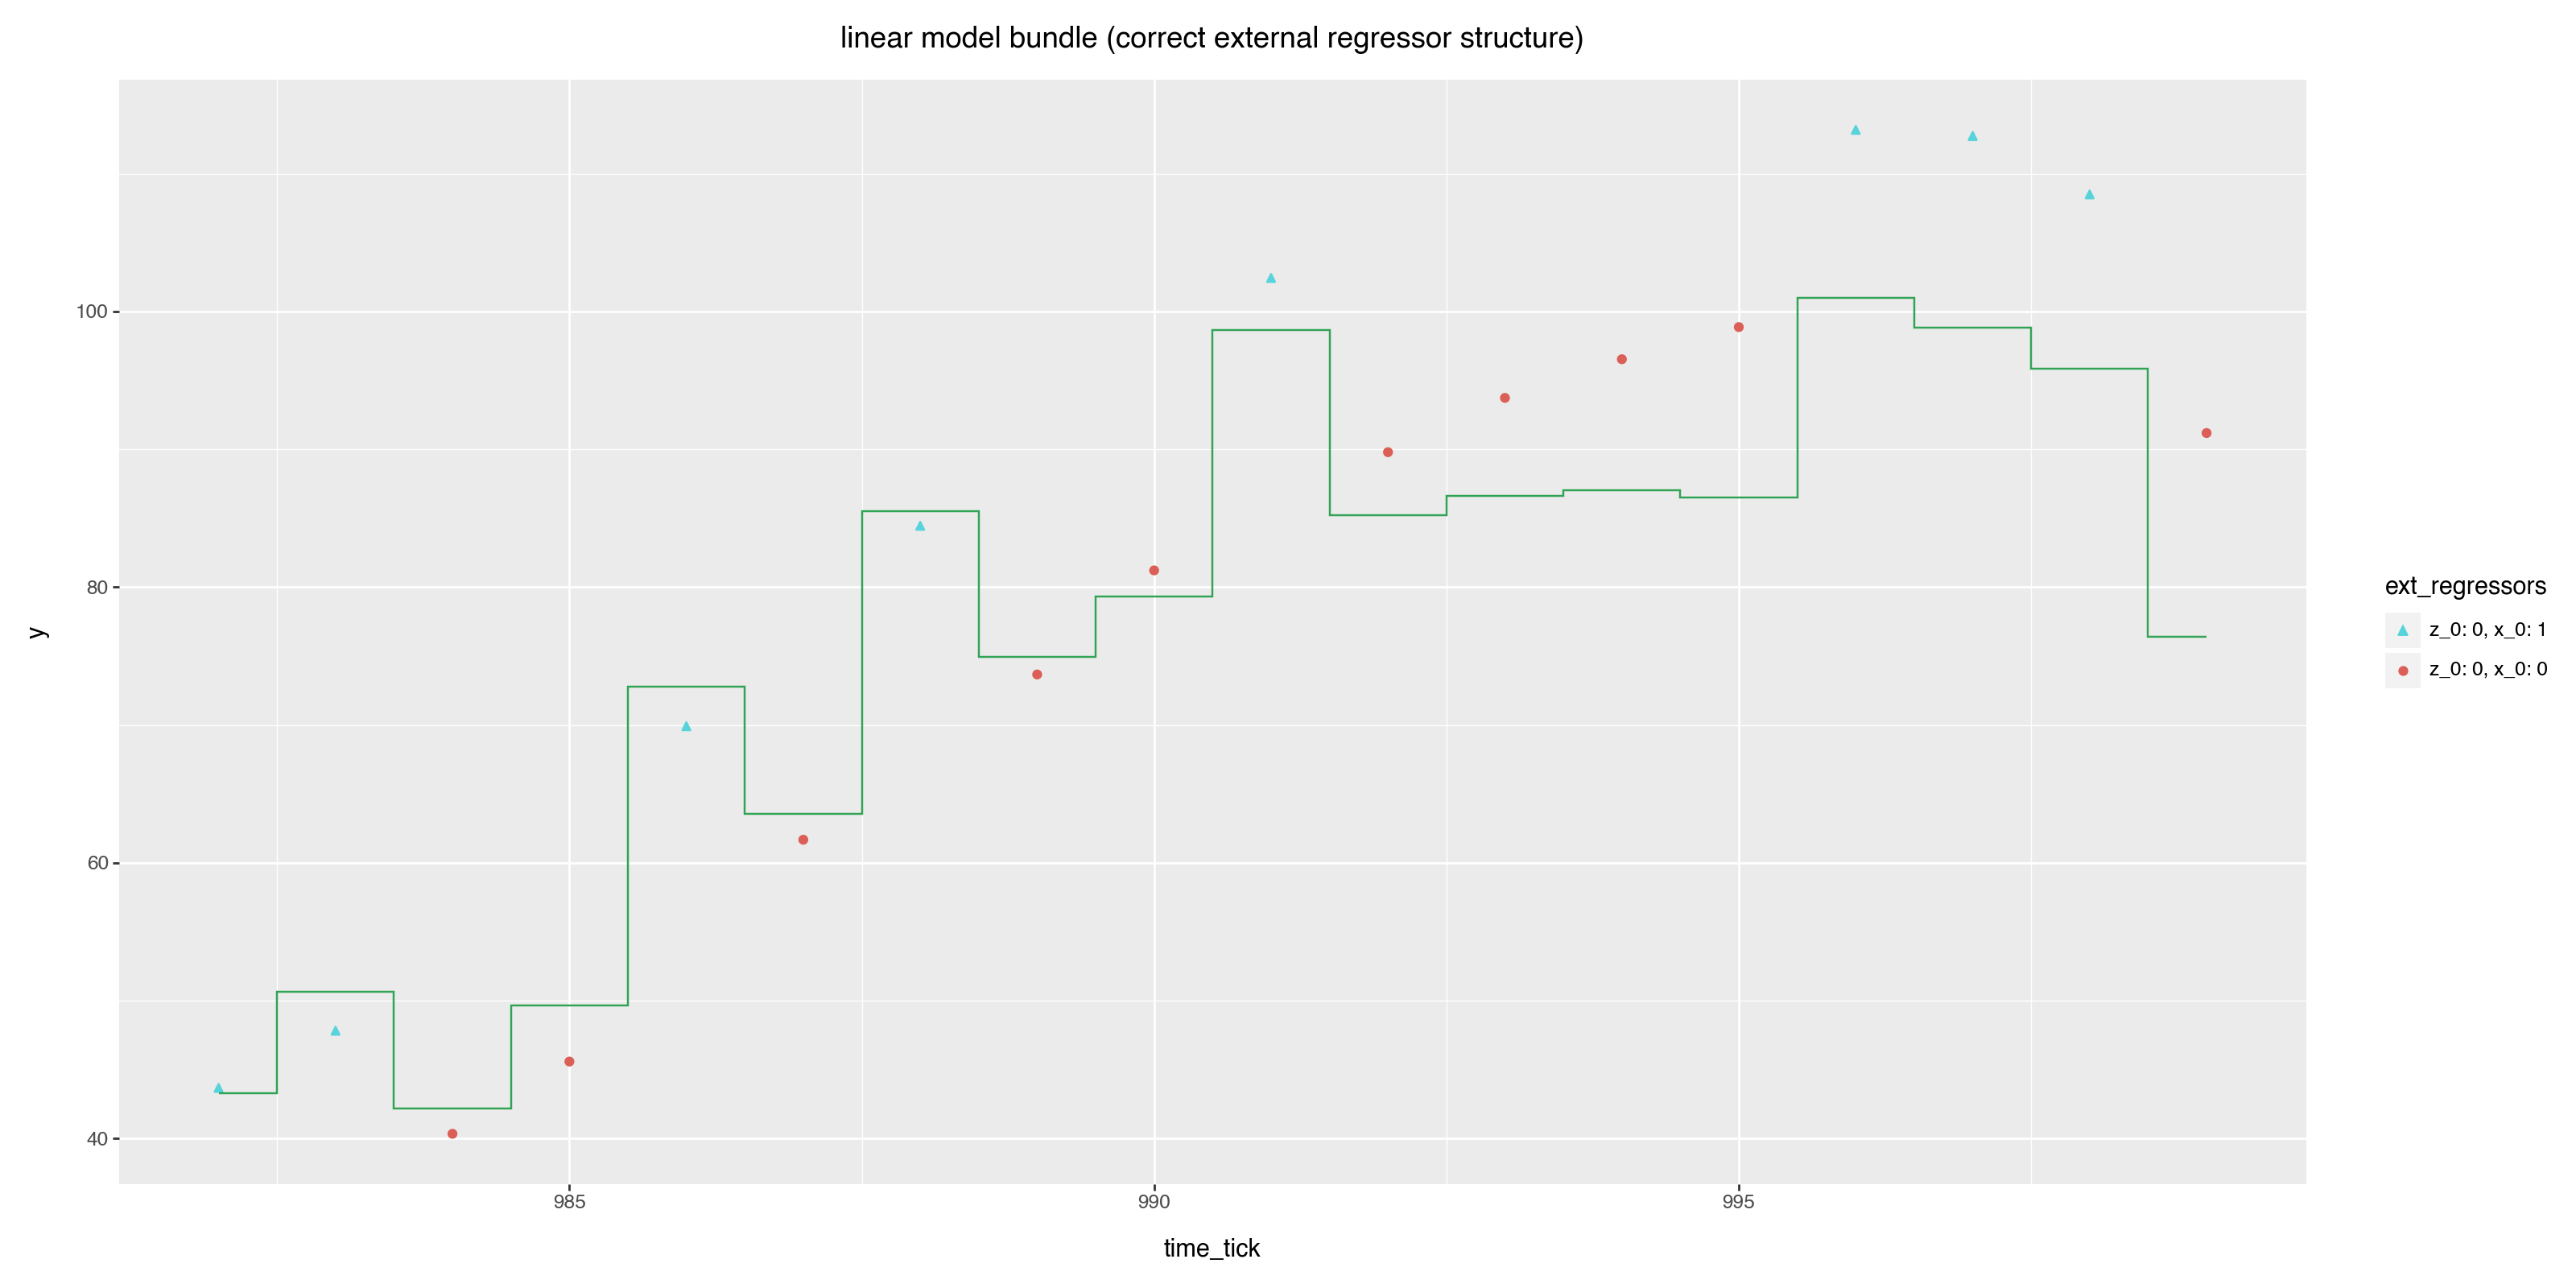

In [18]:
(
    ggplot(
        data=d_test.loc[d_test.notna().all(axis='columns'), :],
        mapping=aes(x='time_tick')
    )
    + geom_point(aes(y='y', shape='ext_regressors', color='ext_regressors'))
    + geom_step(
        aes(y='linear model bundle (correct external regressor structure)'),
        color='#31a354',
        direction='mid',
        )
    + guides(shape=guide_legend(reverse=True))
    + ggtitle("linear model bundle (correct external regressor structure)")
)


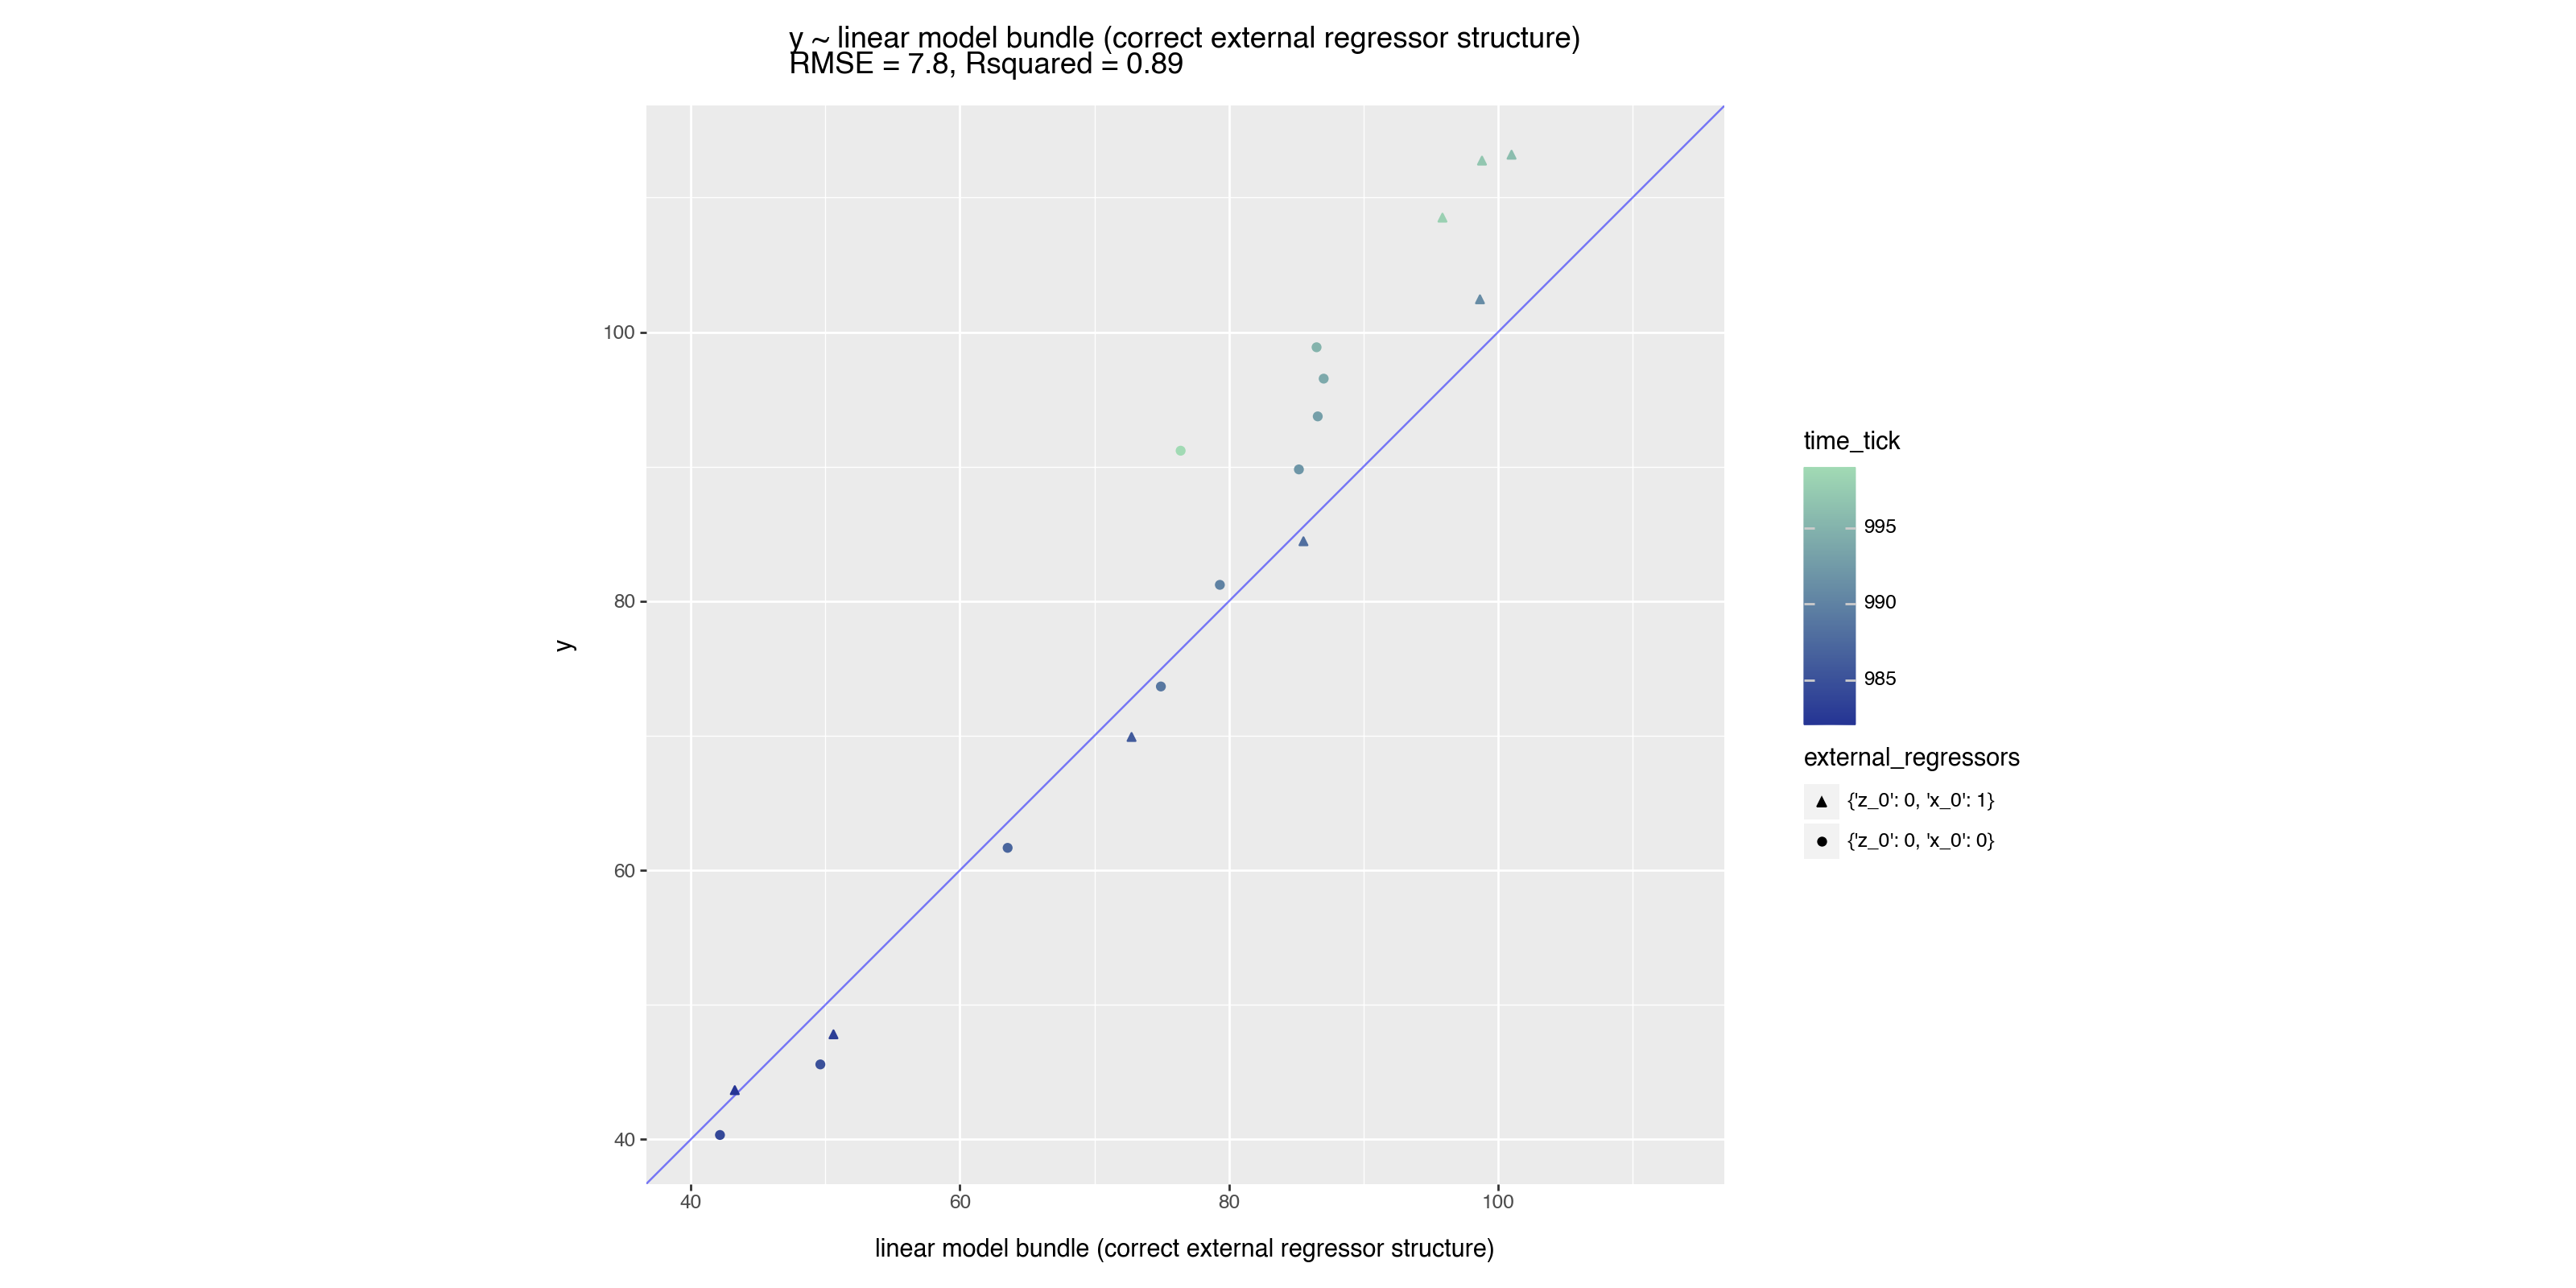

In [19]:
plot_model_quality(
    d_test.loc[pd.isnull(d_test['linear model bundle (correct external regressor structure)']) == False, :],
    result_name='linear model bundle (correct external regressor structure)',
    external_regressors=['z_0', 'x_0'],
)


When the external contributions are already in `y` or "outcome" units, the above can be done properly with an ARX model of section 2.2.1.2 pp.21-22 of Gianluigi Pillonetto , Tianshi Chen , Alessandro Chiuso , Giuseppe De Nicolao , Lennart Ljung *Regularized System Identification*, Springer 2022 (open access link: https://link.springer.com/book/10.1007/978-3-030-95860-2 ). This is *almost* a linear regression with additional equality constraints (to match the lag structure of the external regressors and observed outcomes). When one has to infer the conversion factors from external regressors to outcomes, one has a model with some product terms of inferred quantities (so not a linear model).


## Solving again with the Bayesian "big hammer"

See [Stan_soln.ipynb](Stan_soln.ipynb).


## R packages

Both the forecast and fable R packages [solve the regression with ARIMA residuals formulation quite well](https://github.com/WinVector/Examples/blob/main/TimeSeries/ts_example.md).


## Conclusion


And that concludes our note on modeling in the presence of external regressors. The main point is: one has to specify the structure of the regressors. Do they cause durable effects (such as marketing efforts) or do they cause transient effects (such as one-off sales events)? Also: we would like such specifications to be in terms familiar to domain experts, and not deep in ARMAX or transfer function terminology.
